<b style="font-size: 1.2em;">
    <span style="color: #CA1821;">Insper</span>
    <br/>
    prof. Fábio Pelicano Vieira
</b>
<br/>
<b>Modelagem e Simulação do mundo físico</b>
<br/>
<br/>
<b style>Projeto #2</b>
<br/>
<b style="font-size: 1.4em;">Termodinânima de uma xícara de chá</b>
<br/>
<br/>
<b>Guilherme da Franca Silva Escobar</b>
<br/>
<b>Luciano Felix Dias</b>
<br/>
<b>Rodrigo Paoliello de Medeiros</b>


## Introdução

Este projeto consiste na construção de um modelo que descreve o comportamento termodinâmico de uma xícara de chá com água quente, a fim de estimar sua temperatura ao longo do tempo com a validação de um experimento real, e, a partir disso, tomar consclusões.


**Figura 1  - Esquema do objeto e fluxos de calor**

<img src="esquema.svg" width=400 style="margin-left: 0;"/>

<br/>

**Figura 2  - Diagrama de Estoques e Fluxos**

<img src="fluxograma.svg" width=600 style="margin-left: 0;"/>


### Bibliotecas, coeficientes e parâmetros


In [2]:
from math import pi
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [11]:
# Coeficiente de transferência convectiva do Ar (em W/(m² ⋅ K))
h_ar = 10

# Coeficientes de Condutividade Térmica (em W/(m² ⋅ K))
K_ambiente = 0.58
K_ceramica = 1.05

# Calores Específicos (em J/(kg ⋅ K))
c_agua     = 4180
c_ceramica = 1070

# Densidades (em kg/m³)
D_ceramica = 2403
D_agua     = 1000

# Tempraturas (em ºC)
# Embora o projeto utilize unidades do sistema internacional, as variações de temperatura em ºC são as mesmas em K.
T_ambiente   = 25
T0_xicara    = T_ambiente
T_agua_ideal = 65

# Dimensões do recipiente (em m)
l = 0.005      # Espessura
h = 0.950      # Altura
r = 0.040      # Raio
h_int = h - l  # Altura interna
r_int = r - l  # Raio interno

# Áreas (em m²)
Ab_ext = pi * r**2               # Área da base externa
Ab_int = pi * r_int**2           # Área da base interna
Al_ext = 2 * pi * r * h          # Área lateral externa
Al_int = 2 * pi * r_int * h_int  # Área lateral interna
A_ext  = Ab_ext + Al_ext         # Área externa
A_int  = Ab_int + Al_int         # Área interna
A_mid  = (A_ext + A_int) / 2     # Área intermediária

# Volumes (em m³)
v_agua   = Ab_int * h_int
v_xicara = Ab_ext * h - v_agua

# Massas (em kg)
m_xicara = v_xicara * D_ceramica
m_agua   = v_agua * D_agua

# Resistências térmicas (em K/W)
Rconv_1 = 1 / (h_ar * A_int)
Rcond_1 = (l/2) / (K_ceramica * A_int)
Rcond_2 = (l/2) / (K_ceramica * A_mid)
Rconv_2 = 1 / (h_ar * A_ext)


### Construção do modelo


In [12]:
def modelo (T,t):
    # Temperaturas instantâneas (em K)
    T_agua, T_xicara = T
    
    # Calores (em j/s)
    Q1 = (T_agua - T_ambiente) / Rconv_1
    Q2 = (T_agua - T_xicara) / Rcond_1
    Q3 = (T_xicara - T_ambiente) / (Rcond_2 + Rconv_2)
    
    # Variações de energia interna (em j/s)
    dUadt = - Q1 - Q2
    dUrdt = Q2 - Q3
    
    # Variações de temperatura (em K)
    dTadt = dUadt / (m_agua * c_agua)
    dTrdt = dUrdt / (m_xicara * c_ceramica)
    
    dxdt = (dTadt, dTrdt)
    
    return dxdt


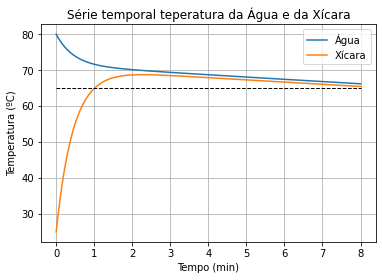

In [13]:
# Tempo (em s)
dt = 1e-2
t_max = 480
tempo_seg = np.arange(0, t_max, dt)

# Tempo (em min)
tempo_min = tempo_seg / 60

# Temperaturas Iniciais (em ºC)
T0_agua = 80
T0 = (T0_agua, T0_xicara)

# Implementação do modelo
T_list = odeint(modelo, T0, tempo_seg)

# Lista das temperaturas ao longo do tempo (em ºC)
T_agua = T_list[:, 0]
T_xicara = T_list[:, 1]

# Plotagem do gráfico
plt.plot(tempo_min, T_agua, label='Água')
plt.plot(tempo_min, T_xicara, label='Xícara')

plt.plot([tempo_min[0], tempo_min[-1]], [65, 65], "k--", lw=1)  # Linha de referencia da temperatura ideal da água

plt.title('Série temporal teperatura da Água e da Xícara')
plt.xlabel('Tempo (min)')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.grid()
plt.savefig('temperatura.png', dpi=300, transparent=True)
plt.show()


### Validação do modelo

Este bloco tem a função de construir um gráfico que compare dados obtidos a partir do modelo consturido nesse projeto e de observações empiricas, com o objetivo de validar o modelo.


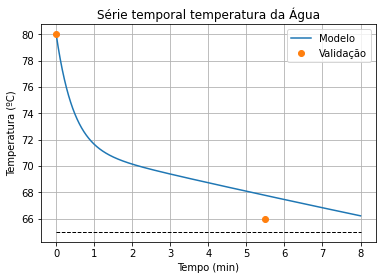

In [27]:
# Temperaturas medidas em experimento
T_agua_validação = (80, 66)

# Tempos das medições
t_min_validação = (0, 5.5)

# Plotagem do gráfico
plt.plot(tempo_min, T_agua, label="Modelo")
plt.plot(t_min_validação, T_agua_validação, "o", label="Validação")

plt.plot([tempo_min[0], tempo_min[-1]], [65, 65], "k--", lw=1)  # Linha de referencia para a temperatura ideal da água

plt.title('Série temporal temperatura da Água')
plt.xlabel('Tempo (min)')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.grid()
plt.savefig('validacao.png', dpi=300, transparent=True)
plt.show()


### Conclusão 1

Com os blocos de código a seguir, busca-se responder a seguinte questão: *Quanto tempo demora para a água atingir a temeratura recomendada para bebidas quentes, dependendo da temperatura inicial da água?*


In [17]:
# Retorna o instante que uma temperatura caindo atinge um determinado valor
def tempo_tempetarura_valor (lista_t, lista_T, T_valor):
    instante = None
    
    for i, temperatura in enumerate(lista_T):
        if temperatura <= T_valor:
            instante = lista_t[i]
            
            break
            
    return instante


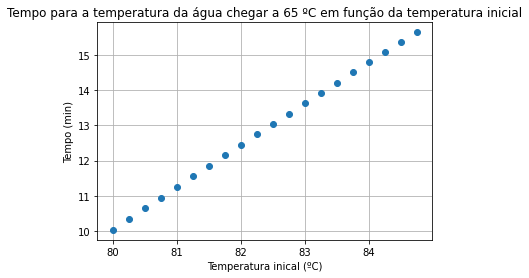

In [28]:
# Tempo (em s)
dt_2 = 1e-1
t_max_2 = 2000
tempo_2_seg = np.arange(0, t_max_2, dt_2)

# Tempo (em min)
tempo_2_min = tempo_2_seg / 60

# Temperaturas Iniciais (em ºC)
lista_T0_agua = np.arange(80, 85, 0.25)

# Tempos que a água chega na tempetarua ideal para cada temperatura inicial
tempos_T_ideal = []

for T0_agua in lista_T0_agua:
    T0 = (T0_agua, T0_xicara)
    
    # Implementação do modelo
    T_list_2 = odeint(modelo, T0, tempo_2_seg)
    T_agua_2 = T_list_2[:, 0]
    
    # Dado conclusivo
    tempo_T_ideal = tempo_tempetarura_valor(tempo_2_min, T_agua_2, T_agua_ideal)
    tempos_T_ideal.append(tempo_T_ideal)
            
# Plotagem do gráfico
plt.plot(lista_T0_agua, tempos_T_ideal, 'o')
plt.title('Tempo para a temperatura da água chegar a 65 ºC em função da temperatura inicial')
plt.ylabel('Tempo (min)')
plt.xlabel('Temperatura inical (ºC)')
plt.grid()
plt.savefig('tempo_xicara.png', dpi=300, transparent=True)
plt.show()


### Conclusão 2

Com os blocos de código a seguir, busca-se responder a seguinte questão: *Quanto tempo demora para a água atingir a temperatura recomendada para bebidas quentes, dependendo da temperatura inicial da água e do material da xícara?*


In [25]:
def modelo_2 (T, t, xicara):
    # Temperaturas instantâneas (em K)
    T_agua, T_xicara = T
    
    # Coeficientes do recipiente (em W/(m² ⋅ K); J/(kg ⋅ K) e kg/m³, respectivamente)
    K_xicara, c_xicara, D_xicara = xicara

    # Massas (em kg)
    m_xicara = v_xicara * D_xicara

    # Resistências térmicas (em K/W)
    Rconv_1 = 1 / (h_ar * A_int)
    Rcond_1 = (l/2) / (K_xicara * A_int)
    Rcond_2 = (l/2) / (K_xicara * A_mid)
    Rconv_2 = 1 / (h_ar * A_ext)
    
    # Calores (em j/s)
    Q1 = (T_agua - T_ambiente) / Rconv_1
    Q2 = (T_agua - T_xicara) / Rcond_1
    Q3 = (T_xicara - T_ambiente) / (Rcond_2 + Rconv_2)
    
    # Variações de energia interna (em j/s)
    dUadt = - Q1 - Q2
    dUrdt = Q2 - Q3
    
    # Variações de temperatura (em K)
    dTadt = dUadt / (m_agua * c_agua)
    dTrdt = dUrdt / (m_xicara * c_xicara)
    
    dxdt = (dTadt, dTrdt)
    
    return dxdt


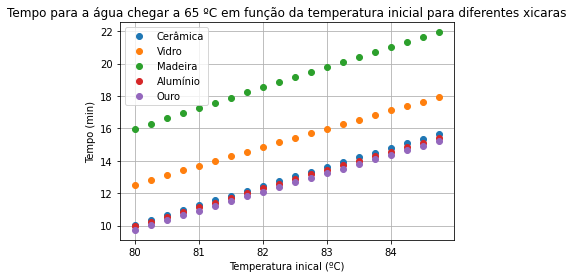

In [29]:
# Coeficientes de Condutividade Térmica (em W/(m² ⋅ K))
K_vidro    = 0.8
K_madeira  = 0.14
K_alumínio = 235
K_ouro     = 327

K_list = (K_ceramica, K_vidro, K_madeira, K_alumínio, K_ouro)

# Calores Específicos (em J/(kg ⋅ K))
c_vidro    = 870
c_madeira  = 2530
c_alumínio = 900
c_ouro     = 129

c_list = (c_ceramica, c_vidro, c_madeira, c_alumínio, c_ouro)

# Densidades (em kg/m³)
D_vidro    = 2190
D_madeira  = 690
D_alumínio = 2700
D_ouro     = 19300

D_list = (D_ceramica, D_vidro, D_madeira, D_alumínio, D_ouro)

# Parâmetros para firerentes materiais de xícaras
materiais_nomes  = ("Cerâmica", "Vidro", "Madeira", "Alumínio", "Ouro")
materiais = zip(K_list, c_list, D_list)

# Tempos que a água chega na tempetarua ideal para cada material
materiais_tempos = []

for material in materiais:
    
    # Tempos que a água chega na tempetarua ideal para temeratura inicial
    material_tempos = []
    
    for T0_agua in lista_T0_agua:
        T0 = (T0_agua, T0_xicara)

        # Implementação do modelo
        T_list_3 = odeint(modelo_2, T0, tempo_2_seg, args=(material, ))
        T_agua_3 = T_list_3[:, 0]
        
        # Dado conclusivo
        material_tempo = tempo_tempetarura_valor(tempo_2_min, T_agua_3, T_agua_ideal)
        material_tempos.append(material_tempo)

    materiais_tempos.append(material_tempos)

# Plotagem do gráfico
for i, material in enumerate(materiais_nomes):
    xicara_tempos = materiais_tempos[i]
    
    plt.plot(lista_T0_agua, xicara_tempos, "o", label=material)
    
plt.title('Tempo para a água chegar a 65 ºC em função da temperatura inicial para diferentes xicaras')
plt.ylabel('Tempo (min)')
plt.xlabel('Temperatura inical (ºC)')
plt.legend()
plt.grid()
plt.savefig('tempos_xicaras.png', dpi=300, transparent=True)
plt.show()
